In [12]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from lightning import Trainer, seed_everything
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from func import FlickrDataset, CLIPDualEncoderModel, Config, get_transform

seed_everything(42)

Global seed set to 42


42

In [2]:
path = Path.home() / 'OneDrive - Seagroup/ai/image_captioning/flickr30k'
image_path = path / 'flickr30k_images'

df = pd.read_csv(path / 'results.csv', delimiter='|')
df.columns = ['image', 'caption_number', 'caption']
for i in df.columns:
    df[i] = df[i].str.lstrip()
df.loc[19999, 'caption_number'] = '4'
df.loc[19999, 'caption'] = 'A dog runs across the grass .'
df['id'] = pd.factorize(df['image'])[0]
df['image_path'] = [str(image_path / i) for i in df['image'].to_numpy()]

print(df.shape)
df.head(7)

(158915, 5)


,image,caption_number,caption,id,image_path
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
4,1000092795.jpg,4,Two friends enjoy time spent together .,0,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
5,10002456.jpg,0,Several men in hard hats are operating a giant...,1,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
6,10002456.jpg,1,Workers look down from up above on a piece of ...,1,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...


In [3]:
pretrain_model = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(pretrain_model)

In [4]:
image_ids = range(0, df['id'].max() + 1)
valid_ids = np.random.choice(image_ids, size=int(0.2 * len(image_ids)), replace=False)
train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]

train = df[df['id'].isin(train_ids)].reset_index(drop=True)
test = df[df['id'].isin(valid_ids)].reset_index(drop=True)
print(train.shape, test.shape)

train_dataset = FlickrDataset(train['image_path'].values.tolist(), train['caption'].values.tolist(),tokenizer=tokenizer)
test_dataset = FlickrDataset(test['image_path'].values.tolist(), test['caption'].values.tolist(),tokenizer=tokenizer)

batch_size = 32
num_workers = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

(127135, 5) (31780, 5)


In [5]:
max_epochs = 3
model = CLIPDualEncoderModel(Config.pretrain_image, Config.pretrain_text, batch_size=batch_size, max_epochs=max_epochs)
model_checkpoint = ModelCheckpoint(dirpath='clip/',
                                   save_top_k=1,
                                   monitor="val_loss",
                                   mode="min",)
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = Trainer(
    accelerator='gpu',
    max_epochs=max_epochs,
    callbacks=[model_checkpoint, lr_monitor],
    deterministic=True,
)
trainer.fit(model,
            train_dataloaders=train_dataloader,
            val_dataloaders=test_dataloader)

You are using a model of type vit to instantiate a model of type resnet. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ResNetModel: ['encoder.layer.11.layernorm_before.bias', 'encoder.layer.1.attention.attention.key.bias', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.9.attention.output.dense.weight', 'encoder.layer.1.attention.attention.key.weight', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.8.layernorm_after.bias', 'layernorm.bias', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.6.output.dense.weight', 'encoder.layer.1.attention.output.dense.weight', 'encoder.layer.8.layernorm_after.weight', 'encoder.layer.4.attention.attention.value.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.8.attention.attention.key.bias', 'encoder.layer.3.attention.output.dense.weight', 'encoder.layer.2.output.

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [6]:
print(f'model path: {model_checkpoint.best_model_path}')
print(f'best loss: {model_checkpoint.best_model_score.cpu().item():,.2f}')
best_model = model.load_from_checkpoint(model_checkpoint.best_model_path).to('cuda')

model path: C:\Users\Kevin\PycharmProjects\ML-learning-journey\multimodal\clip\epoch=2-step=11919.ckpt
best loss: 2.78


You are using a model of type vit to instantiate a model of type resnet. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ResNetModel: ['encoder.layer.11.layernorm_before.bias', 'encoder.layer.1.attention.attention.key.bias', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.9.attention.output.dense.weight', 'encoder.layer.1.attention.attention.key.weight', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.8.layernorm_after.bias', 'layernorm.bias', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.6.output.dense.weight', 'encoder.layer.1.attention.output.dense.weight', 'encoder.layer.8.layernorm_after.weight', 'encoder.layer.4.attention.attention.value.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.8.attention.attention.key.bias', 'encoder.layer.3.attention.output.dense.weight', 'encoder.layer.2.output.

In [7]:
def create_image_embedding(model, dataloader, device='cuda'):
    model.eval()
    image_embeddings, text_embeddings = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Create Image Embedding'):
            # image
            image_features = model.image_encoder(batch["image"].to(device))
            embeb = model.image_projection(image_features)
            image_embeddings.append(embeb.cpu())
            # text
            text_features = model.text_encoder(input_ids=batch["input_ids"].to(device), attention_mask=batch["attention_mask"].to(device))
            text_embeb = model.text_projection(text_features)
            text_embeddings.append(text_embeb.cpu())
    return torch.cat(image_embeddings), torch.cat(text_embeddings)


image_embeddings, text_embeddings = create_image_embedding(best_model, train_dataloader)

Create Image Embedding: 100%|██████████████████████████████████████████████████████| 3973/3973 [04:26<00:00, 14.91it/s]


In [8]:
def compute_score(embed1, embed2):
    embed1 = F.normalize(embed1, p=2, dim=-1)
    embed2 = F.normalize(embed2, p=2, dim=-1)
    return embed1 @ embed2.T

def fletch_images(model, image_embeddings, query, data, n=9):
    print(query)
    # encode
    encoded_query = tokenizer([query])
    batch = {k: torch.tensor(v).to('cuda') for k, v in encoded_query.items()}
    with torch.no_grad():
        text_features = model.text_encoder(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        text_embeddings = model.text_projection(text_features).cpu()
    
    # similar
    dot_similarity = compute_score(image_embeddings, text_embeddings)
    
    # top
    values, indices = dot_similarity.squeeze().topk(n * 5)
    matches = [data['image_path'].values[idx] for idx in indices[::5].cpu()]
    
    # plot
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    
    # ground truth
    ground_truth = data.query(f'caption == "{query}"')['image_path'].values[0]
    ground_truth_image = cv2.imread(ground_truth)
    ground_truth_image = cv2.cvtColor(ground_truth_image, cv2.COLOR_BGR2RGB)
    axes[0].imshow(ground_truth_image)
    axes[0].set_title(f'Ground truth', fontsize=18)
    
    # show
    for i, v in enumerate(matches, start=1):
        image = cv2.imread(v)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].axis("off")
    fig.tight_layout()

    plt.show()

A man in an orange jacket performing snowboarding tricks at a ski resort .


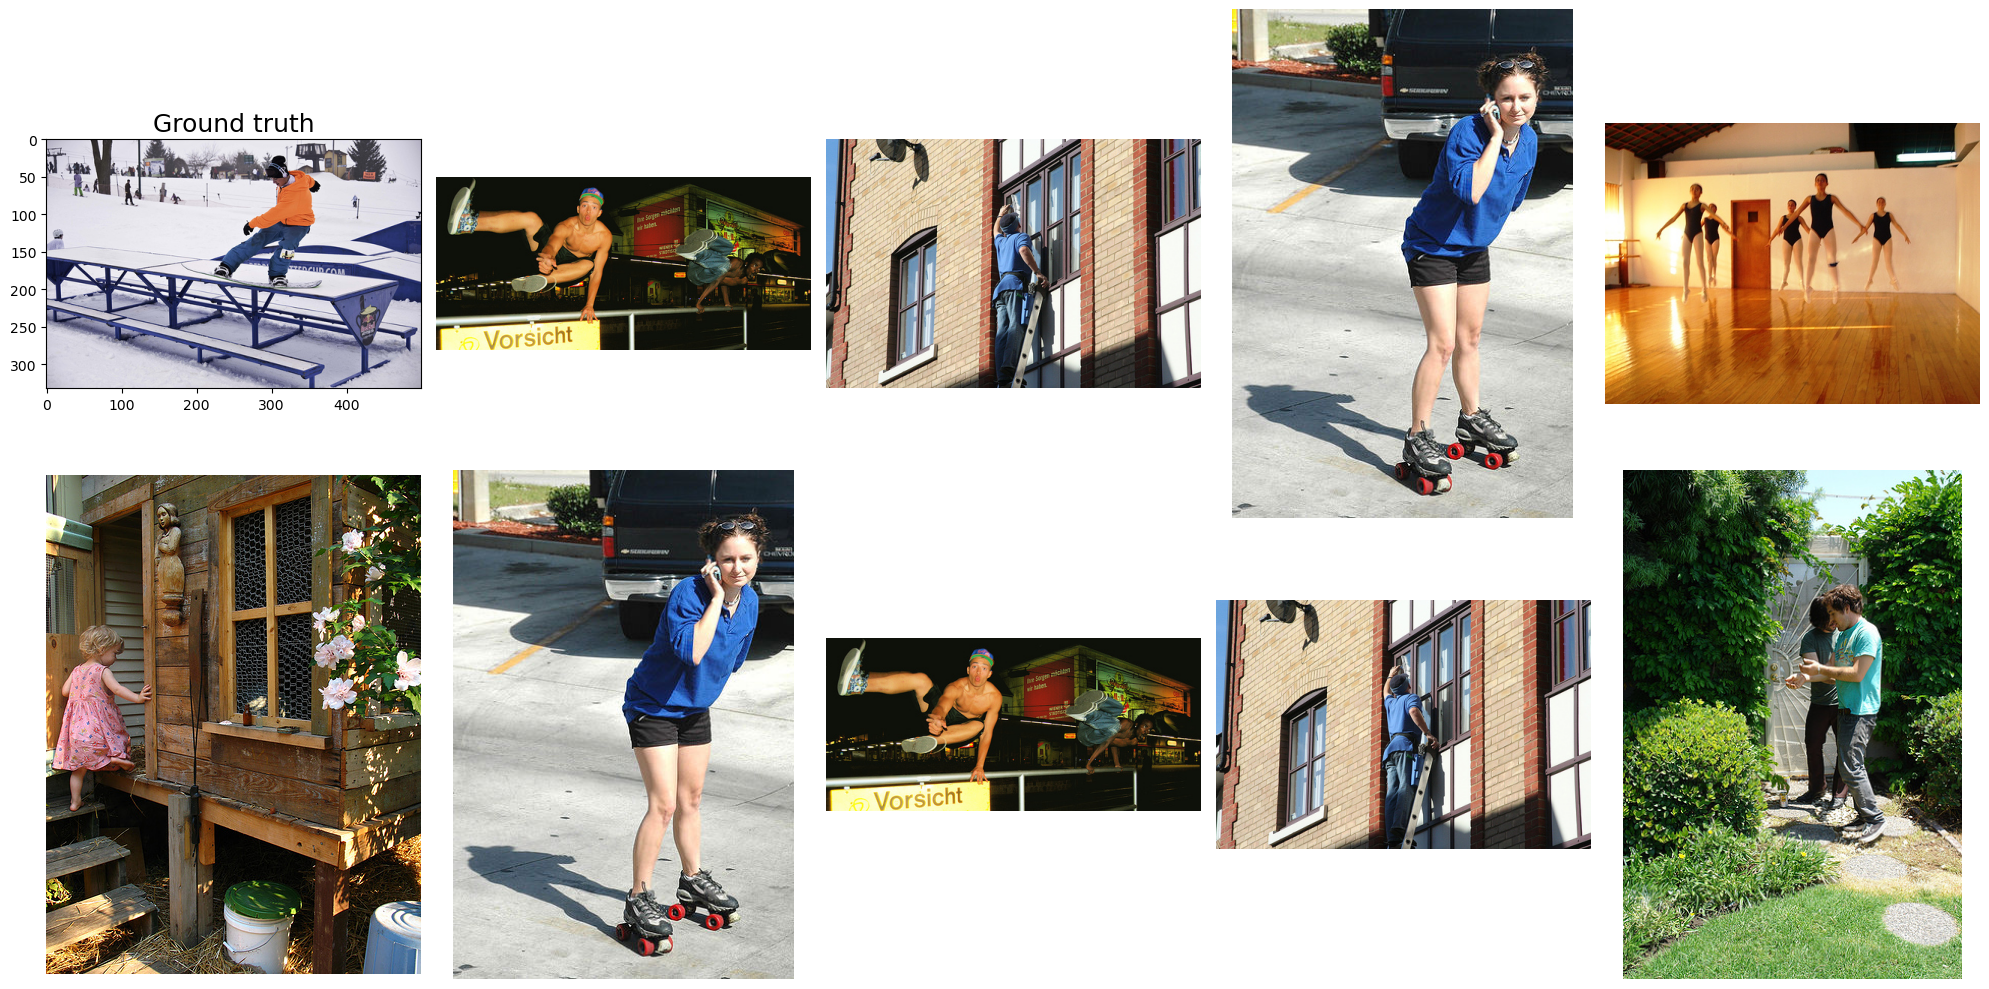

In [9]:
query = train['caption'].sample(1).values[0]
fletch_images(best_model, image_embeddings, query, train)

In [13]:
def fletch_text(model, text_embeddings, query, data, topk=5):
    text_ground_truth = data[data['image_path'] == query]['caption'].values
    for i in text_ground_truth:
        print(f'Ground Truth: {i}')
    ground_truth_image = cv2.imread(query)
    ground_truth_image = cv2.cvtColor(ground_truth_image, cv2.COLOR_BGR2RGB)
    plt.imshow(ground_truth_image)
    plt.axis("off")

    img = get_transform()(image=ground_truth_image)
    img = {k: torch.tensor(v).permute(2, 0, 1).unsqueeze(0).float().to('cuda') for k, v in img.items()}
    with torch.no_grad():
        image_features = model.image_encoder(img['image'])
        embeb = model.image_projection(image_features).cpu()

    # similar
    dot_similarity = compute_score(embeb, text_embeddings)
    values, indices = dot_similarity.squeeze().topk(topk)
    matches = [data['caption'].values[idx] for idx in indices.cpu()]
    for i in matches:
        print(i)

Ground Truth: Two young guys with shaggy hair look at their hands while hanging out in the yard .
Ground Truth: Two young , White males are outside near many bushes .
Ground Truth: Two men in green shirts are standing in a yard .
Ground Truth: A man in a blue shirt standing in a garden .
Ground Truth: Two friends enjoy time spent together .
A man in a blue shirt standing in a garden .
Two friends enjoy time spent together .
Two young , White males are outside near many bushes .
Two young guys with shaggy hair look at their hands while hanging out in the yard .
Two men in green shirts are standing in a yard .


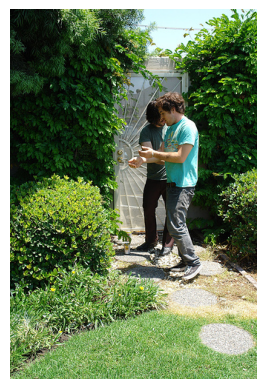

In [14]:
query = train['image_path'].values[0]
fletch_text(best_model, text_embeddings, query, train)